# [LANL competition](https://www.kaggle.com/c/LANL-Earthquake-Prediction)
- [introduction](https://www.kaggle.com/c/LANL-Earthquake-Prediction/discussion/77525)
- [Benchmark analysis](https://www.kaggle.com/inversion/basic-feature-benchmark/notebook)
- [good EDA and discussion + comments](https://www.kaggle.com/allunia/shaking-earth/comments)

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
os.path.abspath('.')

'/home/ben/github/LANL/notebooks'

In [3]:
version='v5'

In [4]:
root = 'D:\\LANL\\all' # windows
root = '/media/ben/data/kaggle/LANL/' # linux
os.listdir(root)

['all.zip',
 'sample_submission.csv',
 'test',
 'test.zip',
 'train.csv',
 'v1_submission.csv',
 'v1_train.hdf',
 'v2_submission.csv',
 'v2_train.hdf',
 'v3.1_submission.csv',
 'v3_submission.csv',
 'v4.1_nuSVR_submission.csv',
 'v4.1_submission.csv',
 'v4.2_XGB_submission.csv',
 'v5.0_Ensemble_submission.csv']

# Load Training Data

In [5]:
# # load 9GB csv
# train = pd.read_csv(os.path.join(root,'train.csv'), dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})

### Failure sequences
There are 16 failures in the data set, but the time-to-fail only ever reaches very small decimals.<br>
The last rows do *NOT* end in a failure. 

- when loading the data..
- Lets, use the time difference to identify where the T2F jumps back up and mark these as failures.

In [6]:
try:
    train = pd.read_hdf(os.path.join(root,'v2_train.hdf'.format(version)),'mydata')
    print('File Loaded')
except:
    print('File not found, running chunk load')
    # load in as chunks
    chunksize = 10 ** 6
    chunks = list()
    sequenceNumber = 0 # first failure sequence
    
    for chunk in tqdm(pd.read_csv(os.path.join(root,'train.csv'),
                             dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64},
                             chunksize=chunksize)):

        chunk['seq'] = chunk['time_to_failure'].diff() # get time difference between each step
        chunk['seq'] = (chunk['seq']>0).astype(float).copy() # float binary column where time_difference between steps is positive (i.e. reset after failure)
        chunk['seq'].values[0] = sequenceNumber # set first as sequenceNumber
        chunk['seq'] = chunk['seq'].cumsum().copy() # sum up sequence values
        chunks.append(chunk) # append results to list
        sequenceNumber = chunk['seq'].values[-1] # get latest sequnce number
        
    # concat chunks & save
    train = pd.concat(chunks)
    print('Out:{}'.format(len(train)))
    train.to_hdf(os.path.join(root,'{}_train.hdf'.format(version)),'mydata',mode='w')

File Loaded


In [7]:
# pandas doesn't show us all the decimals
pd.options.display.precision = 15
train.head()

,acoustic_data,time_to_failure,seq
0,12,1.4690999832,0.0
1,6,1.4690999821,0.0
2,8,1.4690999810,0.0
3,5,1.4690999799,0.0
4,8,1.4690999788,0.0


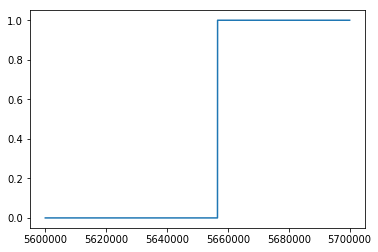

In [8]:
# lets check our sequnces worked on a known failure point
train['seq'][5600000:5700000].astype(float).plot();

In [9]:
sequences = np.arange(0,17,1)
sequenceDict = dict()
for seq in sequences:
    sequenceDict[seq] = train.loc[train['seq']==seq].reset_index(drop=True)
    print('Seq:{}, {}'.format(seq, len(sequenceDict[seq])), end='\r\n')

Seq:0, 5656574
Seq:1, 44429304
Seq:2, 54591478
Seq:3, 34095097
Seq:4, 48869367
Seq:5, 31010810
Seq:6, 27176955
Seq:7, 62009332
Seq:8, 30437370
Seq:9, 37101561
Seq:10, 43991032
Seq:11, 42442743
Seq:12, 33988602
Seq:13, 32976890
Seq:14, 56791029
Seq:15, 36417529
Seq:16, 7159807


# Training Data Prep

1. There are 150,000 rows in each test segment. 
2. The training data is reduced from 6 millions rows to summary features every 150,000 rows. (~5000 summary rows).
3. Lets use our sequenceFailure data to avoid summarising over failure points e.g. (5,4,3,2,1,0,5,4,3,2,1) 

## Feature Engineering

In [10]:
test = sequenceDict[0]
test1 = test[-150000:]
x = test1['acoustic_data']

In [11]:
def getSequenceSegments(sequenceDF,rows):
    segments = int(np.floor(sequenceDF.shape[0] / rows))
    return segments

In [12]:
getSequenceSegments(test,150000)

37

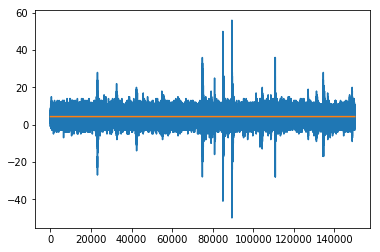

In [13]:
plt.plot(x.values)
plt.plot([x.mean()]*len(x))
#plt.plot(((x-x.mean())/x.std()).values)

In [14]:
def getFeatures(sequenceDF,seqID,getY=bool):
    acoustics = sequenceDF['acoustic_data'].copy()
    x = acoustics.values
    
    X_train = pd.DataFrame({'segID':seqID,
                            'ave':x.mean(),
                            'median':np.median(x),
                            'std':x.std(),
                            'max':x.max().astype(float),
                            'min':x.min().astype(float),
                            'total':abs(x).sum().astype(float), # total abs acoustic
                            'cumul':abs(x).cumsum().sum().astype(float),
                            'PoT05':len(x[(x >= x.mean()+0.5*x.std()) | (x <= x.mean()-0.5*x.std())])/len(x), # peaks over/under threshold (1*std)
                            'PoT1':len(x[(x >= x.mean()+1*x.std()) | (x <= x.mean()-1*x.std())])/len(x), # peaks over/under threshold (1*std))
                            'PoT2':len(x[(x >= x.mean()+2*x.std()) | (x <= x.mean()-2*x.std())])/len(x), # peaks over/under threshold (1*std)
                            'PoT3':len(x[(x >= x.mean()+3*x.std()) | (x <= x.mean()-3*x.std())])/len(x), # peaks over/under threshold (1*std)
                            'RDN1':float(len(x[abs(x)/abs(x).mean()>=1])), # rainy day normal
                            'RDN2':float(len(x[abs(x)/abs(x).mean()>=2])), # rainy day normal
                            'RDN4':float(len(x[abs(x)/abs(x).mean()>=4])), # rainy day normal
                            'RDN8':float(len(x[abs(x)/abs(x).mean()>=6])), # rainy day normal
                            'RDN12':float(len(x[abs(x)/abs(x).mean()>=7])), # rainy day normal
                            'meanDiff':acoustics.diff().mean(), # change per step [max, median]
                            'stdDiff':acoustics.diff().std(), #  change per step [max, median]
                            'maxDiff':acoustics.diff().max(), #  change per step [max, median]
                            'Q001Diff':np.quantile(x,0.001), # Quantile
                            'Q01Diff':np.quantile(x,0.01), # Quantile
                            'Q05Diff':np.quantile(x,0.05), # Quantile
                            'Q10Diff':np.quantile(x,0.10), # Quantile
                            'Q999Diff':np.quantile(x,0.999), # Quantile
                            'Q99Diff':np.quantile(x,0.99), # Quantile
                            'Q95Diff':np.quantile(x,0.95), # Quantile
                            'Q90Diff':np.quantile(x,0.90), # Quantile
                            'Qrng10-90':np.subtract(*np.percentile(x, [90, 10])) # Quartile Range from 0.05 to 0.95% (range of values)
                           },index=[0])
    
    # IF so that we can re-use this later and not pass any y's
    if getY == True:
        y = sequenceDF['time_to_failure'].values[-1]
        y_train = pd.DataFrame({'segID':seqID,
                                'time_to_failure':y},index=[0])
        return X_train, y_train
    else:
        return X_train

In [15]:
getFeatures(test,99,getY=False)

,segID,ave,median,std,max,min,total,cumul,PoT05,PoT1,...,maxDiff,Q001Diff,Q01Diff,Q05Diff,Q10Diff,Q999Diff,Q99Diff,Q95Diff,Q90Diff,Qrng10-90
0,99,4.560983026121465,5.0,23.427838329705629,3252.0,-4621.0,35185198.0,97168998187958.0,0.041876054304248,0.014699887246238,...,882.0,-69.0,-14.0,-3.0,0.0,79.0,24.0,12.0,10.0,10.0


In [16]:
# for r in [10,5000,20000,]:
#     x.rolling(window=r,min_periods=r).mean().plot()
    
# plt.plot(x.index, [x.mean()]*len(x))
# plt.plot(x.index, [x.mean()+x.std()]*len(x))
# plt.plot(x.index, [x.mean()-x.std()]*len(x))

In [17]:
# Create a training file with simple derived features
Xs = list()
ys = list()
rows = 150000
segID = 0

for seq in sequences:
    print(seq, end=',')
    sequenceDF = sequenceDict[seq].copy() # take copy of entire failure sequence
    nSegments = getSequenceSegments(sequenceDF,rows) # get number of 150,000 row segments per sequence
    
    for segment in range(nSegments):
        segDF = sequenceDF.iloc[segment*rows:segment*rows+rows].copy()
        xDF,yDF = getFeatures(segDF,segID,getY=True)
        segID+=1
        Xs.append(xDF)
        ys.append(yDF)
    
    # manually add the last 150,000 to capture failure
    segDF = sequenceDF[-rows:].copy()
    xDF,yDF = getFeatures(segDF,segID,getY=True)
    segID+=1
    Xs.append(xDF)
    ys.append(yDF)

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,

In [18]:
X_train = pd.concat(Xs,sort=False).reset_index(drop=True)
y_train = pd.concat(ys,sort=False).reset_index(drop=True)

In [19]:
X_train.head()

,segID,ave,median,std,max,min,total,cumul,PoT05,PoT1,...,maxDiff,Q001Diff,Q01Diff,Q05Diff,Q10Diff,Q999Diff,Q99Diff,Q95Diff,Q90Diff,Qrng10-90
0,0,4.884113333333334,5.0,5.101089126891323,104.0,-98.0,836485.0,65908881756.0,0.474920000000000,0.182500000000000,...,32.0,-30.0,-8.0,-2.0,0.0,40.00000000000000,18.0,11.0,10.0,10.0
1,1,4.725766666666667,5.0,6.588801819164257,181.0,-154.0,860125.0,66025576390.0,0.336520000000000,0.115280000000000,...,78.0,-47.0,-11.0,-2.0,0.0,59.00000000000000,21.0,12.0,10.0,10.0
2,2,4.906393333333333,5.0,6.967373808828945,140.0,-106.0,922897.0,66426535142.0,0.362873333333333,0.121560000000000,...,47.0,-47.0,-15.0,-3.0,0.0,59.00000000000000,26.0,13.0,10.0,10.0
3,3,4.902240000000000,5.0,6.922282112791032,197.0,-199.0,890094.0,67391753310.0,0.340106666666667,0.101206666666667,...,68.0,-50.0,-12.0,-2.0,0.0,60.00099999998929,22.0,12.0,10.0,10.0
4,4,4.908720000000000,5.0,7.301085852684289,145.0,-126.0,916588.0,67425069281.0,0.342166666666667,0.091966666666667,...,43.0,-56.0,-15.0,-2.0,0.0,65.00000000000000,26.0,12.0,10.0,10.0


# Feature Selection
- https://blog.datadive.net/selecting-good-features-part-iv-stability-selection-rfe-and-everything-side-by-side/

### [Simple RFE](https://medium.com/@aneesha/recursive-feature-elimination-with-scikit-learn-3a2cbdf23fb7)
 - https://scikit-learn.org/stable/auto_examples/feature_selection/plot_rfe_digits.html#sphx-glr-auto-examples-feature-selection-plot-rfe-digits-py
 - https://www.kaggle.com/shrutigodbole15792/feature-selection
 - https://ramhiser.com/post/2018-03-25-feature-selection-with-scikit-learn-pipeline/

### [RFE Pipelines](https://stackoverflow.com/questions/32208546/combining-recursive-feature-elimination-and-grid-search-in-scikit-learn)
 - https://stackoverflow.com/questions/36683230/grid-search-with-recursive-feature-elimination-in-scikit-learn-pipeline-returns

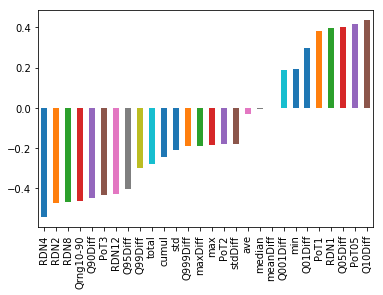

In [35]:
X_train.iloc[:,1:].corrwith(y_train.iloc[:,1]).sort_values().plot.bar();
#pd.plotting.scatter_matrix(X_train.iloc[:,1:],figsize=(15,15));
#(X_train.iloc[:,1:].corr())[abs(X_train.iloc[:,1:].corr()>0.5)]

In [36]:
from sklearn.feature_selection import RFE,RFECV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

  7%|▋         | 2/28 [00:00<00:01, 15.93it/s]

N features = 28


100%|██████████| 28/28 [00:00<00:00, 28.44it/s]


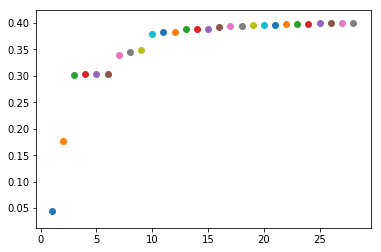

In [37]:
nFeatures = len(X_train.iloc[:,1:].columns)
print('N features = {}'.format(nFeatures))

scaler = StandardScaler()
scaler.fit(X_train.iloc[:,1:])
X_train_scaled = scaler.transform(X_train.iloc[:,1:])

# create the RFE model and select attributes
estimator = LinearRegression()

rfeResults = dict()

for x in tqdm([x for x in range(1,nFeatures+1,1)]):
    rfe = RFE(estimator, n_features_to_select=x, step=1)
    #rfe = RFECV(estimator, min_features_to_select=x, step=1, cv=5)
    rfe = rfe.fit(X_train_scaled, y_train.iloc[:,1].values.flatten())
    rfeResults[x] = rfe
    
for k,v in rfeResults.items():
    # print summaries for the selection of attributes
    plt.scatter(k,v.score(X_train_scaled, y_train.iloc[:,1].values.flatten()))
    #print(v.support_)
    #print(v.ranking_)

In [40]:
rfeResults[16].support_

array([ True, False,  True,  True,  True,  True, False, False, False,
        True,  True,  True,  True,  True,  True, False, False,  True,
       False,  True,  True,  True,  True, False,  True,  True,  True,
        True])

In [263]:
# take columns wth best support
X = X_train[X_train.iloc[:,1:].columns[rfeResults[16].support_]].copy()
y = y_train.iloc[:,1].copy()

# Clustering 

### - [GMM](https://www.datascience.com/blog/k-means-alternatives)
### - [GMM Sklearn](https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_covariances.html#sphx-glr-auto-examples-mixture-plot-gmm-covariances-py)
### - [Clustering with GMM](https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_selection.html)

In [264]:
scaler = StandardScaler()
scaler.fit(X)
X_train_scaled = scaler.transform(X)

/home/ben/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


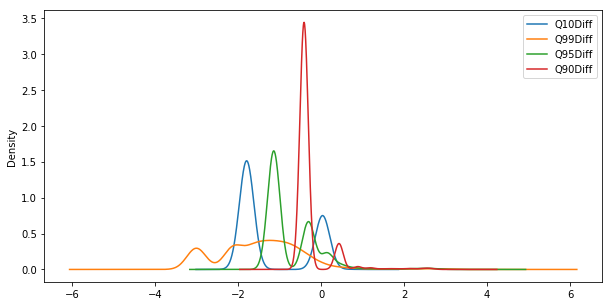

In [282]:
pd.DataFrame(np.log(X_train_scaled),columns=X.columns).iloc[:,11:15].plot.kde(legend=True, figsize=(10,5))
#plt.xlim(-3,3);

In [235]:
#Predict GMM cluster membership
from sklearn.mixture import GaussianMixture

GMMresults = {}
inst = {}
bic = []
n_components_range = range(1, 16)
cv_types = ['spherical', 'tied', 'diag', 'full']

for n_components in n_components_range:
    comp = {}
    for cv_type in cv_types:
        GMM = GaussianMixture(n_components=n_components,
                              covariance_type=cv_type,
                              max_iter=300,).fit(X_train_scaled)
        #GMM.predict(X)
        comp[cv_type] = GMM.bic(X_train_scaled)
        inst['{}_{}'.format(n_components,cv_type)] = GMM
        
    GMMresults[n_components] = comp

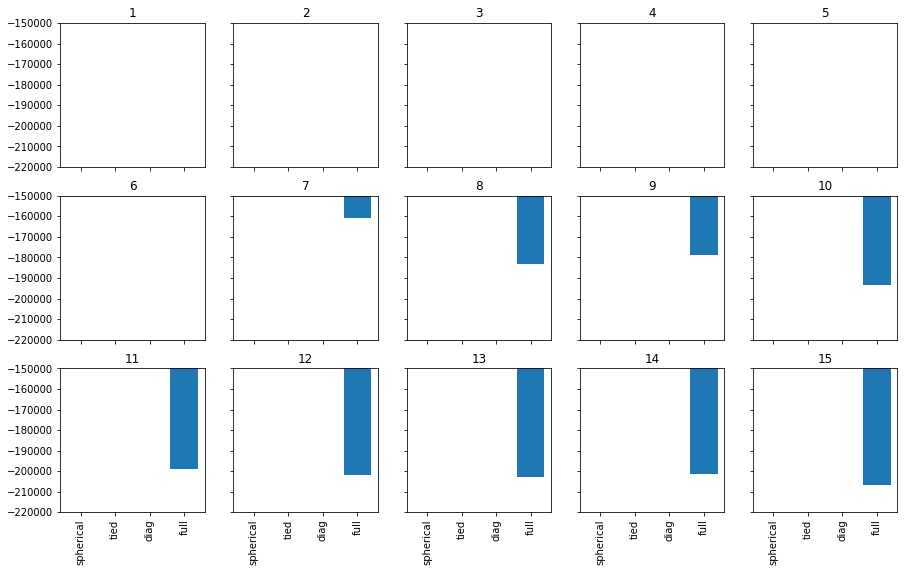

In [241]:
fig,axs = plt.subplots(3,5,figsize=(15,9),sharex=True,sharey=True)

for n_components,ax in zip(n_components_range,axs.flatten()):
    ax.bar([0,1,2,3],[v for (k,v) in GMMresults[n_components].items()])
    ax.set_xticks([0,1,2,3])
    ax.set_xticklabels(['spherical', 'tied', 'diag', 'full'],rotation=90)
    ax.set_title(n_components)
    ax.set_ylim(-220000,-150000)

In [253]:
GMM = GaussianMixture(n_components=15,
                              covariance_type='full',
                              max_iter=300,).fit(X_train_scaled)
GMM.predict(X_train_scaled)

array([13, 13,  9, ...,  2,  2,  2])

In [254]:
X['cluster'] = GMM.predict(X_train_scaled)
X['y'] = y

In [259]:
X.groupby(['cluster']).mean().T.loc['y']

cluster
0     4.513966156336707
1     0.291964614473333
2     9.130986160700981
3     5.426075208848505
4     2.244725760340000
5     0.298508111639000
6     8.034196480670294
7     2.666867072155408
8     7.051003849769583
9     2.734738626813784
10    2.502540977278696
11    5.653172599825000
12    4.242493387041113
13    3.931418561056406
14    7.768509930189910
Name: y, dtype: float64

 - ### Choosing N Cluster
 - [Silhouette Score](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html)
 - [Cluster Score](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)
### [KNN](https://www.analyticsvidhya.com/blog/2018/08/k-nearest-neighbor-introduction-regression-python/)
 - [sklearn doc](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)
 - [clustered regression](https://stats.stackexchange.com/questions/139042/ensemble-of-different-kinds-of-regressors-using-scikit-learn-or-any-other-pytho)

In [42]:
# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
#  scores = https://stackoverflow.com/questions/32370543/understanding-score-returned-by-scikit-learn-kmeans
from sklearn.cluster import KMeans

# silhoutte scoring
# https://stackoverflow.com/questions/51138686/how-to-use-silhouette-score-in-k-means-clustering-from-sklearn-library
# https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py
from sklearn.metrics import silhouette_samples, silhouette_score

scaler = StandardScaler()
scaler.fit(X)
X_train_scaled = scaler.transform(X)

silhouetteScores = list()
Kclusters = np.arange(10,120,10)

k_score = {}
for k in tqdm(Kclusters):
    KM = KMeans(n_clusters=k,
                init='k-means++',
                max_iter=300,
                n_init=25,
                n_jobs=-1)
    
    KM = KM.fit(X_train_scaled)
    k_score[k] = KM.score(X_train_scaled)
    
    preds = KM.fit_predict(X_train_scaled)
    centers = KM.cluster_centers_
    score = silhouette_score 
    silhouetteScores.append(silhouette_score(X_train_scaled, preds, metric='euclidean'))
#     silhouetteScores.append(silhouette_score(X, KM.labels_, sample_size=10000, random_state=99))

100%|██████████| 11/11 [01:24<00:00, 10.04s/it]


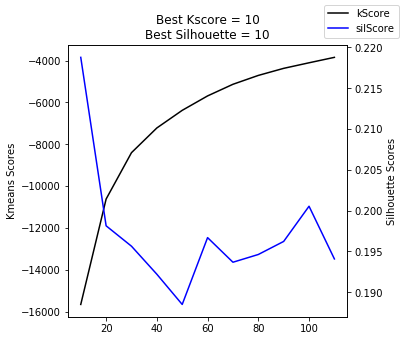

In [43]:
# interpret
fig,axs = plt.subplots(1,1,figsize=(5,5))

silScore = Kclusters[np.argmax(silhouetteScores)]
kScore = Kclusters[np.argmin([v for k,v in k_score.items()])]

axs.plot(k_score.keys(),k_score.values(), color='black', label='kScore');
axs.set_ylabel('Kmeans Scores')

ax2 = axs.twinx()
ax2.plot(Kclusters,silhouetteScores, color='blue', label='silScore');
ax2.set_ylabel('Silhouette Scores')

axs.set_title('Best Kscore = {}\n'\
              'Best Silhouette = {}'.format(kScore,silScore))
fig.legend();

In [ ]:
KM = KMeans(n_clusters=10,
            init='k-means++',
            max_iter=300,
            n_init=25,
            n_jobs=-1
           )
KM.fit(X_train_scaled)

In [ ]:
# take columns wth best support
X = X_train[X_train.iloc[:,1:].columns[rfeResults[15].support_]].copy()
y = y_train.iloc[:,1].values.flatten().copy()

X['Clusters'] = KM.predict(X_train_scaled).astype(float)

# manual refit 3 to 9
X.loc[X['Clusters']==3.0,'Clusters'] = 9.0
X['Clusters'].value_counts().plot.bar(figsize=(15,4));

In [ ]:
X['y'] = y
X.groupby('Clusters').mean()

In [ ]:
data = {}

for k in X['Clusters'].unique():
    dat = dict()
    dat['X'] = X.loc[X['Clusters']==k].iloc[:,:-2].reset_index(drop=True).copy()
    dat['y'] = X.loc[X['Clusters']==k].iloc[:,-1].reset_index(drop=True).copy()
    data[k] = dat

# Train, Predict & Score
 - [notes on feature scaling](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_scaling_importance.html)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error, make_scorer

In [ ]:
MAEscorer = make_scorer(mean_absolute_error, greater_is_better=False)
models = dict()

### [NuSVR](https://scikit-learn.org/stable/modules/generated/sklearn.svm.NuSVR.html#sklearn.svm.NuSVR)

In [ ]:
from sklearn.svm import NuSVR
def makeSVR():
    pipe = Pipeline([('scaler', StandardScaler()),
                     ('pca',PCA()),
                     ('model', NuSVR())])

    params = {'pca__n_components': [2,4,6],
              'model__kernel':['rbf'],
              'model__nu': [0.5,0.75,0.9],
              'model__C': [1,2,2.5],
              'model__gamma': ['auto'],
              }

    gs_NuSVR = GridSearchCV(estimator=pipe,
                            param_grid=params,
                            scoring=MAEscorer,
                            n_jobs=-1,
                            iid=False,
                            cv=3)
    return gs_NuSVR

# %time gs_NuSVR = gs_NuSVR.fit(X,y)

# print('\n',gs_NuSVR.best_score_,'\n', gs_NuSVR.best_params_,)
# models.append(gs_NuSVR)

### [XGBRegressor](https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn)

In [ ]:
from xgboost import XGBRegressor

def makeXGB():
    pipe = Pipeline([('scaler', StandardScaler()),
                     ('pca',PCA()),
                     ('model', XGBRegressor())])

    params = {'pca__n_components': [2,4,6],
              'model__max_depth':[3,4,5,10],
              'model__learning_rate': [0.001,0.01,0.1],
              'model__n_estimators': [25,30,35,50],}

    gs_XGB = GridSearchCV(estimator=pipe,
                          param_grid=params,
                          scoring=MAEscorer,
                          n_jobs=-1,
                          iid=False,
                          cv=3)
    return gs_XGB

# %time gs_XGB = gs_XGB.fit(X,y)
# print('\n',gs_XGB.best_score_,'\n', gs_XGB.best_params_,)
# models.append(gs_XGB)

### [Elasticnet](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html#sklearn.linear_model.ElasticNet)

In [ ]:
from sklearn.linear_model import ElasticNet

def makeEN():
    pipe = Pipeline([('scaler', StandardScaler()),
                     ('pca',PCA()),
                     ('model', ElasticNet())])

    params = {'pca__n_components': [2,4,6],
              'model__alpha':[0.5,1.0],
              'model__l1_ratio': [0.75,1.0],
              'model__max_iter': [1000],}

    gs_EN = GridSearchCV(estimator=pipe,
                         param_grid=params,
                         scoring=MAEscorer,
                         n_jobs=-1,
                         iid=False,
                         cv=3)
    return gs_EN

# %time gs_EN = gs_EN.fit(X,y)
# print('\n',gs_EN.best_score_,'\n', gs_EN.best_params_,)
# models.append(gs_EN)

In [ ]:
for k,v in data.items():
    
    svr = makeSVR()
    v['SVR'] = svr.fit(v['X'],v['y'])
    v['SVR_score'] = v['SVR'].best_score_
    
    xgb = makeXGB()
    v['XGB'] = xgb.fit(v['X'],v['y'])
    v['XGB_score'] = v['XGB'].best_score_
    
    eNet = makeEN()
    v['eNet'] = eNet.fit(v['X'],v['y'])
    v['eNet_score'] = v['eNet'].best_score_

In [ ]:
results = pd.DataFrame([(k,v['eNet_score'],v['XGB_score'],v['SVR_score']) for k,v in data.items()], columns=['K','eNet','XGB','SVR'])
results['best'] = results.iloc[:,1:].idxmax(axis=1)
results.sort_values(by='K',inplace=True)
results

# Predict on Test Data and Write Submission

In [ ]:
submission = pd.read_csv(os.path.join(root,'sample_submission.csv'), index_col='seg_id')
submission.head()

In [ ]:
X_tests = list()
for seg_id in tqdm(submission.index[:]):
    seg = pd.read_csv(os.path.join(root,os.path.join('test',seg_id))+ '.csv')
    X_tests.append(getFeatures(seg,seg_id,getY=False))

In [ ]:
X_test = pd.concat(X_tests).set_index(keys='segID',drop=True)

In [ ]:
# take columns wth best support
X_test = X_test[X_test.iloc[:,:].columns[rfeResults[15].support_]].copy()
X_test.head()

In [ ]:
scaler = StandardScaler()
scaler.fit(X_test)
X_test_scaled = scaler.transform(X_test)
X_test['Clusters'] = KM.predict(X_test_scaled).astype(float)

# manual refit 3 to 9
X_test.loc[X_test['Clusters']==3.0,'Clusters'] = 9.0
X_test['pred'] = np.float()

In [ ]:
for k,mod in results[['K','best']].values:
    print(k,mod, data[k]['{}_score'.format(mod)])
    X_test.loc[X_test['Clusters']==k,'pred'] = data[k][mod].predict(X_test.loc[X_test['Clusters']==k].iloc[:,:-2])

In [ ]:
results

In [ ]:
data[4]['SVR_score']

In [ ]:
submission['time_to_failure'] = X_test['pred']
print(len(submission))
submission.head()

In [ ]:
submission.isnull().sum()

In [ ]:
submission.to_csv(os.path.join(root,'{}.0_Ensemble_submission.csv'.format(version)))

# 4.1 NuSVR is new best 1.522

## next trials
 - RFE with grid search
 - [catBoost](https://www.kaggle.com/jazivxt/aftershock?scriptVersionId=9634938)
 - [See this kernel](https://www.kaggle.com/artgor/earthquakes-fe-more-features-and-samples)
